#### Importing all the necessary libraries

In [0]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix
import math
import seaborn as sns
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

#### Importing train and test data

In [0]:
df_train = pd.read_csv("Weather Forecast Training.csv")
df_test = pd.read_csv("Weather Forecast Testing.csv")

#### Getting familiar with the data

#### Training dataset is a mixture of numerical and categorical variables.
#### It has 16 evaluation parameters with 51987 observations.

In [97]:
#print(df_train.head(10))
print(df_train.columns)
print(df_train.shape)
print(df_train.dtypes)

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir', 'WindSpeed', 'Humidity',
       'Pressure', 'Cloud', 'Temp', 'RainToday', 'RainTomorrow'],
      dtype='object')
(51978, 16)
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir           object
WindSpeed        float64
Humidity         float64
Pressure         float64
Cloud            float64
Temp             float64
RainToday         object
RainTomorrow      object
dtype: object


#### Statistically investigating the data

#### Here we observe that training dataset has 'RainTomorrow' variable, which is missing in test data, ideally correct. Also, Test data has an additional attribute 'ID' - primary key. 

#### Most of the variables in both the dataset are approximately normally skewed.

#### Important point to notice here is that all the variables have diffrent standard deviation. The point acts as a base for the requirement of scaling the data before using clustering algorithms.

In [98]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MinTemp,51694.0,12.549174,6.376746,-8.0,7.9,12.3,17.2,31.4
MaxTemp,51849.0,22.512698,7.113064,-4.1,17.2,21.8,27.5,47.0
Rainfall,51231.0,3.639494,11.009628,0.0,0.0,0.0,2.2,371.0
Evaporation,29425.0,5.177570,4.017662,0.0,2.4,4.4,7.0,77.3
Sunshine,27103.0,6.530580,3.946561,0.0,3.2,6.9,9.9,14.5
WindGustSpeed,48407.0,42.003016,14.627024,7.0,31.0,39.0,50.0,135.0
WindSpeed,50954.0,19.092299,9.157505,0.0,13.0,19.0,24.0,83.0
Humidity,50549.0,57.432214,21.833045,1.0,42.0,58.0,73.0,100.0
Pressure,46912.0,1014.273338,7.278733,977.1,1009.3,1014.2,1019.2,1037.8
Cloud,31848.0,5.175647,2.632166,0.0,3.0,6.0,7.0,8.0


In [99]:
df_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,12994.0,6497.500000,3751.189034,1.0,3249.25,6497.5,9745.75,12994.0
MinTemp,12947.0,12.497969,6.388597,-6.5,7.90,12.1,17.10,29.7
MaxTemp,12976.0,22.491685,7.099027,-3.7,17.30,21.7,27.40,46.9
Rainfall,12833.0,3.650495,11.031150,0.0,0.00,0.0,2.20,367.6
Evaporation,7478.0,5.148930,4.021726,0.0,2.40,4.4,7.00,86.2
Sunshine,6900.0,6.577928,3.933243,0.0,3.20,7.0,9.90,14.0
WindGustSpeed,12074.0,42.016730,14.741531,7.0,31.00,39.0,50.00,135.0
WindSpeed,12733.0,19.078379,9.200108,0.0,13.00,19.0,24.00,87.0
Humidity,12645.0,57.240490,21.854321,1.0,42.00,58.0,73.00,100.0
Pressure,11701.0,1014.200752,7.296169,980.2,1009.30,1014.2,1019.10,1037.2


#### Combining train and test data to perform data cleaning with keeping in mind that later we'll have to seperate them. Hence, we add a additional dummy variable in combined data with '1' for train and '0' for test data.

In [0]:
df_train["if_train"] = 1
df_test["if_train"] = 0

df_total = df_train.append(df_test)

## Data Cleaning

#### Column-wise summing the Missing values in dataset.

#### Evaporation, Sunshine and Cloud have very large number of missing values. 
#### Target variable has 12994 missing values which is equal to length of test data. We will confirm it further in our analysis.
#### ID variable has 51978 missing values which is equal to length of training data.
#### Other variables also have significant amount of missing values, which we'll have to impute. 

In [101]:
df_total.isna().sum()

Cloud            25150
Evaporation      28069
Humidity          1778
ID               51978
Location             0
MaxTemp            147
MinTemp            331
Pressure          6359
RainToday          908
RainTomorrow     12994
Rainfall           908
Sunshine         30969
Temp              1330
WindDir           1900
WindGustDir       4527
WindGustSpeed     4491
WindSpeed         1285
if_train             0
dtype: int64

#### Filtering the columns with more than 20% of Missing Values

#### Sunshine, Cloud and Evaporation have 48%, 43% and 38% missing values resp.

In [102]:
dirty_var = df_total.isnull().sum(axis=0).sort_values( ascending=False)/len(df_total)
dirty_var[ dirty_var > 0.20]

ID             0.800006
Sunshine       0.476651
Evaporation    0.432017
Cloud          0.387090
dtype: float64

#### These variables have ~ 40%! Even if we try to impute them with central values, it'll disturb the variance and distribution of data. Hence, we decide to drop Sunshine, Evaporation and Cloud variables. Since ID column is not needed for training data, the missing values are justified.

In [0]:
df_total.drop(['Evaporation'] , axis = 1, inplace = True)
df_total.drop(['Cloud'] , axis = 1, inplace = True)
df_total.drop(['Sunshine'] , axis = 1, inplace = True)

#### First, cleaning the categorical variables. For that, we use the most frequent value of the column to impute in place of Missing Values.

In [0]:
#df_train.dtypes

df_total.RainToday.fillna(df_total.RainToday.mode()[0], inplace=True)
df_total.WindDir.fillna(df_total.WindDir.mode()[0], inplace=True)
df_total.WindGustDir.fillna(df_total.WindGustDir.mode()[0], inplace=True)

#### Before cleaning the numerical variables, we plot the boxplot for each and every one of them to check the distribution and see if they contain outliers. The reason for that is when we calculate the mean/median value for imputation, it should not contain the outliers. 

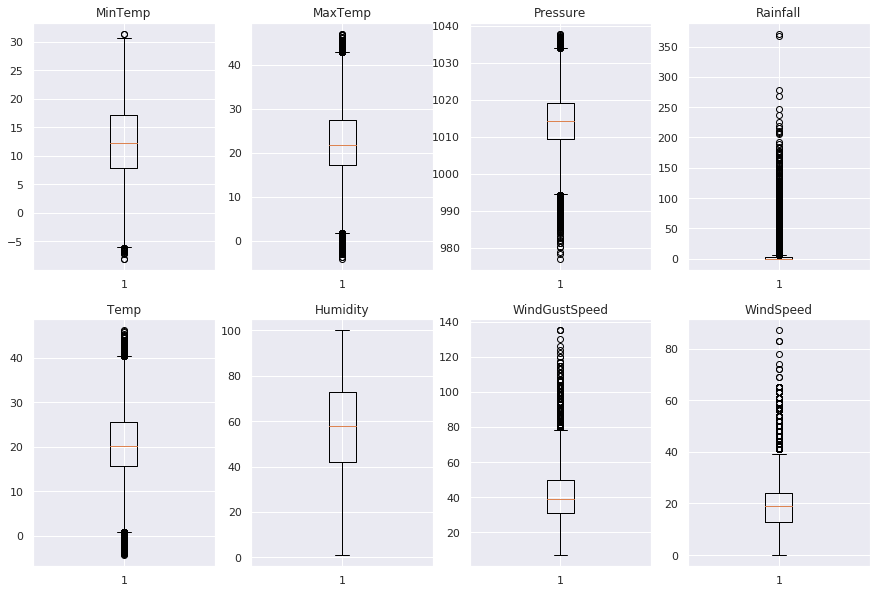

In [105]:
num_var = ['MinTemp', 'MaxTemp', 'Pressure', 'Rainfall', 'Temp', 'Humidity', 'WindGustSpeed', 'WindSpeed']

plt.figure(figsize=(15,10))

for i in range(len(num_var)):
    plt.subplot(2,4,i+1)
    plt.boxplot(df_total[num_var[i]].dropna())
    plt.title(num_var[i])

#### We create a user defined function, where we will use the IQR method to treat outliers by winsoring. Then after that, we use that function to treat the variables for outliers. Except 'humidity', every variable needs to be treated for outliers. 

In [0]:
def out_treat(var):
    Q1 = np.quantile(var.dropna(), 0.25)
    Q3 = np.quantile(var.dropna(), 0.75)
    IQR = Q3-Q1
    LC = Q1 - (1.5 * IQR)
    UC = Q3 + (1.5 * IQR)
    var[var > UC] = UC
    var[var < LC] = LC
    return(var)

df_total.MinTemp       = out_treat(df_total.MinTemp)
df_total.MaxTemp       = out_treat(df_total.MaxTemp)
df_total.Pressure      = out_treat(df_total.Pressure)
df_total.Rainfall      = out_treat(df_total.Rainfall)
df_total.Temp          = out_treat(df_total.Temp)
df_total.WindGustSpeed = out_treat(df_total.WindGustSpeed)
df_total.WindSpeed     = out_treat(df_total.WindSpeed)

#### Now we can impute the Missing Values in numerical variable by the mean/median of that column. To decide between mean and median, we plot the histogram to check the distribution and skewness for each variable and decide what is the best estimate for Missing Values. Some variables are normally distributed but most of them are skewed, so impute the missing values with median.

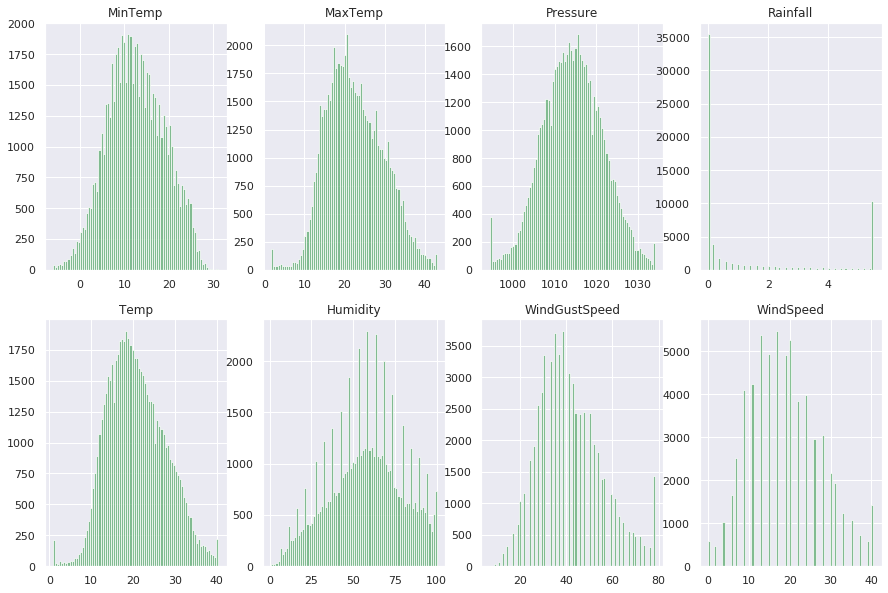

In [107]:
plt.figure(figsize=(15,10))
for i in range(len(num_var)):
    plt.subplot(2,4,i+1)
    plt.hist(df_total[num_var[i]], bins = 80, alpha = 0.7, histtype = 'bar', facecolor = 'g')
    plt.title(num_var[i])

### Group by 'RainToday' justification: Rainfall is the product of specific enviornmental parameters. We all know that water evaporates, becomaes vapor and then condenses back to liquid form to what we term as 'Rainfall'. For water condensing back to liquid form, the parameters such as pressure, temperature, wind etc needs to attain specific values. It means, the enviornmental parameters must be having different values on a rainy day than any normal day. 

### Hence, we group the data by 'RainToday' variable, and then impute the Missing values by the median value of that particular group for each and every variable.

In [0]:
for i in range(len(num_var)):
    df_total[num_var[i]] = df_total.groupby(["RainToday"])[num_var[i]].transform(lambda x: x.fillna(x.median()))

#### After imputing the Missing values with median, new outliers may be created in few variables. Rechecking the boxplot and treating those variables for outliers again.

In [0]:
df_total.MinTemp     = out_treat(df_total.MinTemp)
df_total.Pressure    = out_treat(df_total.Pressure)
df_total.Rainfall    = out_treat(df_total.Rainfall)
df_total.Temp        = out_treat(df_total.Temp)

#### Now, we seperate the training and testing data set. Dropping the 'if_train' variable from both test and train dataset. Also, dropping 'ID' var from train dataset.

In [0]:
df_train1 = df_total[df_total.if_train == 1]
df_test1 = df_total[df_total.if_train == 0]

df_train1.drop(['if_train'] , axis = 1, inplace = True)
df_test1.drop(['if_train'] , axis = 1, inplace = True)

df_train1.drop(['ID'] , axis = 1, inplace = True)

## Exploratory Data Analysis

### Analysing target variable.

#### Statistically analysing target variable.

#### Target variable is a categorical variable with 2 levels.

In [111]:
df_train1.RainTomorrow.describe()

count     51978
unique        2
top          No
freq      26459
Name: RainTomorrow, dtype: object

#### Displaying the observations about target variable.

In [112]:
print("The target variable has", df_train1.RainTomorrow.isnull().sum(), "missing values")
print("The target variable has", df_train1.RainTomorrow.nunique(), "unique values")
print("They are: ", df_train1.RainTomorrow.unique()[0], "and", df_train1.RainTomorrow.unique()[1])
print("Percentage distribution of values:", df_train1.RainTomorrow.value_counts()/len(df_train1))

The target variable has 0 missing values
The target variable has 2 unique values
They are:  Yes and No
Percentage distribution of values: No     0.509042
Yes    0.490958
Name: RainTomorrow, dtype: float64


#### Plotting the frequency distribution for the target variable. 

### This is a balanced dataset. The target variable values 'Yes' and 'No' are equally distributed.

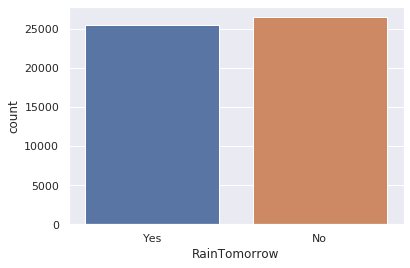

In [113]:
rtm_bar = sns.countplot(x=df_train1.RainTomorrow)

### Analysing Numerical variables.

#### First, plotting the correlation plot for all the numerical variables.

#### Observations:
#### 1] MaxTemp and Temp variables are very highly correlated: r = 0.96
#### 2] Rainfall and Humidity have a very interesting correlation of r = 0.42
#### 3] Another interesting correlation is between Temp and Humidity of r = -0.55
#### 4] Another interesting observation is that 'Pressure' is negatively correlated with all the temperature variables.
#### 5] Also, Pressure is highly negatively correlated with WindGustSpeed with r = -0.38

In [114]:
corr = df_train1.corr()
corr.style.background_gradient(cmap='BrBG')

,Humidity,MaxTemp,MinTemp,Pressure,Rainfall,Temp,WindGustSpeed,WindSpeed
Humidity,1,-0.48498,0.0248851,-0.0210501,0.42317,-0.551776,0.0262128,-0.0036616
MaxTemp,-0.48498,1,0.738053,-0.311234,-0.225682,0.962846,0.0140291,0.0174115
MinTemp,0.0248851,0.738053,1,-0.368983,0.0829835,0.697724,0.126896,0.120534
Pressure,-0.0210501,-0.311234,-0.368983,1,-0.145621,-0.268595,-0.384243,-0.215734
Rainfall,0.42317,-0.225682,0.0829835,-0.145621,1,-0.23295,0.192805,0.0875996
Temp,-0.551776,0.962846,0.697724,-0.268595,-0.23295,1,-0.0272193,-0.000736592
WindGustSpeed,0.0262128,0.0140291,0.126896,-0.384243,0.192805,-0.0272193,1,0.643906
WindSpeed,-0.0036616,0.0174115,0.120534,-0.215734,0.0875996,-0.000736592,0.643906,1


### Bivariate Analysis

### RainTomorrow vs Humidity
#### Humidity for RainTomorrow = No is pretty much normally distributed. But for the RainTomorrow = Yes, it is left skewed. This justifies the relation of humidity with rainfall. Areas with high humidity will receive high rainfall.

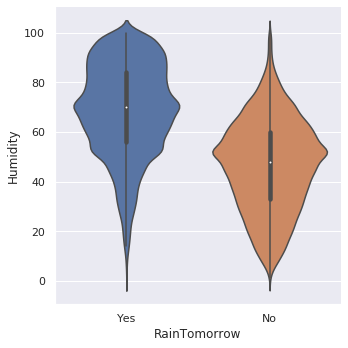

In [115]:
plot1 = sns.catplot(x="RainTomorrow", y="Humidity", kind="violin", split=True, data=df_train1);

### RainTomorrow vs Rainfall (w.r.t. RainToday)

#### This graph helps us to know about the prediction of rainfall for tomorrow based on the quantity of rainfall that happened today. As you can see, High rainfall for RainToday = Yes, the chances for RainTomorrow are more.

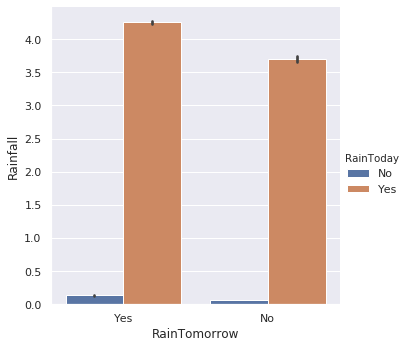

In [116]:
plot2 = sns.catplot(x="RainTomorrow", y="Rainfall", hue="RainToday", kind="bar", data=df_train1);

### Temp vs MaxTemp
#### This graph justifies the correlaton value of Temp and MaxTemp. Such high correlation between 2 independant variables can often cause multicollinearity in regression problems.

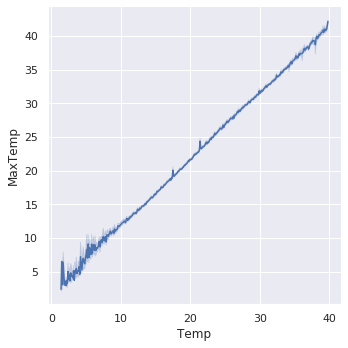

In [117]:
plot3 = sns.relplot(x="Temp", y="MaxTemp", kind="line", data=df_train1)

### Temp vs Humidity
#### As the humidity increases the temperature decreases. Both the conditions are suitable for condesation and hence are good for rainfall to happen.

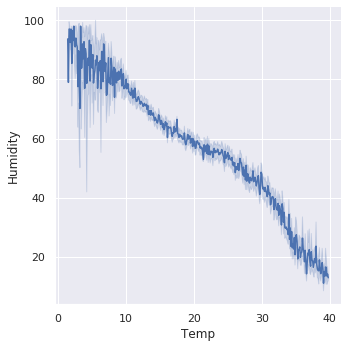

In [118]:
plot4 = sns.relplot(x="Temp", y="Humidity", kind="line", data=df_train1)

### Humidity vs Rainfall
#### We know humidity can cause rainfall. But the thing to observe here is that they are linearly related. As the humidity goes on increasing the amount of rainfall will also be more.

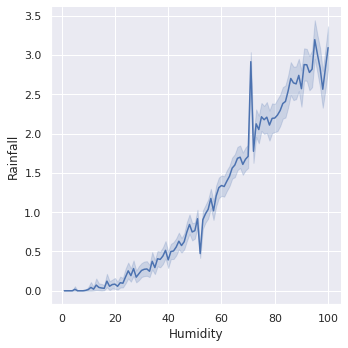

In [119]:
plot5 = sns.relplot(x="Humidity", y="Rainfall", kind="line", data=df_train1);

### Rainfall vs WindDir
#### Very interesting point here is that winds blowing from south or west direction have more count for rainfall i.e. they bring more rain as compared to winds from any other direction.

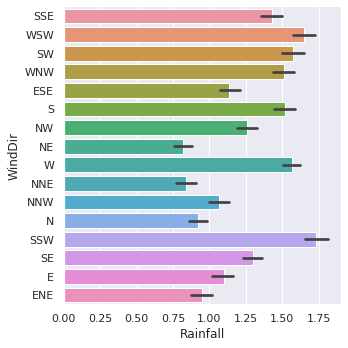

In [120]:
plot6 = sns.catplot(x="Rainfall", y="WindDir", kind="bar", data=df_train1);

### Converting the categorical variables to dummies and save the dataset.

In [0]:
df_train2 = pd.get_dummies(df_train1)

### Seperating the target variable from training dataset and deleting one of the dummies of binary level categorical variables.

In [0]:
df_target2 = pd.DataFrame(df_train2.RainTomorrow_Yes)

#Saving dummy of RainTomorrow_No, might be helpful for kmeans clustering classification
actual_kmeans = pd.DataFrame(df_train2.RainTomorrow_No)

df_train2.drop(['RainTomorrow_Yes'] , axis = 1, inplace = True)
df_train2.drop(['RainTomorrow_No'] , axis = 1, inplace = True)
df_train2.drop(['RainToday_No'] , axis = 1, inplace = True)

### Classify training dataset into further training and testing (validation) dataset. (75-25 split)

In [0]:
x_train,x_test,y_train,y_test = train_test_split(df_train2,df_target2,test_size=0.25, random_state=7)

# Decision Tree

#### Deploying model over training dataset, predicting over test dataset and calculating the accuracy score.

In [124]:
trial_model = tree.DecisionTreeClassifier().fit(x_train, y_train)
predicted_values = trial_model.predict(x_test)
print(f"Accuracy: {round(metrics.accuracy_score(y_test, predicted_values)*100)}%")

Accuracy: 71.0%


#### Checking the recall, precision and f1 score for the classification

In [125]:
print(classification_report(y_test, predicted_values))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      6561
           1       0.71      0.71      0.71      6434

    accuracy                           0.71     12995
   macro avg       0.71      0.71      0.71     12995
weighted avg       0.71      0.71      0.71     12995



## Finding the best hyperparameters

#### Here we use the grid search to try multiple combinations of some parameters on our model to get the best accuracy and recall.
#### Recall: In this particular case, type 2 error is more dangerous than type 1 error. If rain tomorrow = yes and we predict it a a no, then that error can be more harmful than error 1. Hence, we focus on 'Recall' evaluation parameter bcause recall deals with false negatives.

#### min_samples_split: This parameter is to contrained model for node splitting if certain number of minimmum records are present in that node. The best value we got here is '2'. Unfortunately, this arises the question of overfitting of model on training data. Ideally, min_sample_split should lie between 1 to 40. Hence, we choose 10,20 to choose from to which he grid search returns 10 as the best value for our model.

#### max_depth: This parameter deals with the levels in decison tree. The best value return for the tree model by grid search was 5. Unfortunately, it might create constrain on tree model and cause the model to be underfitted. So, we increase max_depth to 10, if tree still considers 5 as the best value then it can still create tree with 5 levels.

#### max_leaf_nodes: This parameter deals with maximum number of leaf nodes that a model can generate. Best value returned was 80 leaf nodes increasing the accuracy to 78%. Unfortunately, again the question of overfitting arises because of so many leaf nodes. With new values model returns 30 as the best value for our model.

#### min_samples_leaf: Minimum number of records to be present in leaf node. The more the records in leaf nodes, reduced the chances of overfitting. A very high number can also cause underfitting.

#### Criteria: The parameter based on which you evaluate the importance of a node. The difference between parent node and child nodes combined is calculated. The higher the better. It can be calulated using either GINI index or entropy. Here the grid returns GINI index as the evaluation parameter as it helps in finding the best combinatons f child and parent nodes while genrating the decision tree. 

#### Using grid search to find the optimum value of hyper parameters in order to fine tune the model.

In [0]:
#Model Hyperparameter Fine Tuning
            #param_grid = {'criterion': ['gini', 'entropy'],
            #              'min_samples_split': [10,20],
            #              'max_depth': [10,15],
            #              'max_leaf_nodes': [25,30],
            #              'min_samples_leaf' : [9,10,11]}
            #grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
            #grid.fit(x_train, y_train)

#Output Best Model Hyperparameters
            #print(grid.best_score_)

            #for hps, values in grid.best_params_.items():
            #  print(f"{hps}: {values}")

#### Using the best parameters, applying the the model again to the training dataset and checking for the accuracy.

In [127]:
model = tree.DecisionTreeClassifier(min_samples_split = 10, max_depth = 10, min_samples_leaf = 9, max_leaf_nodes = 30, random_state=73).fit(x_train, y_train)
predictions=model.predict(x_test)
print(f"Accuracy: {round(metrics.accuracy_score(y_test, predictions)*100)}%")

Accuracy: 76.0%


#### Create a confusion matrix and plot it.

#### Here we observe that False negative is less than false positives. It means our recall value will be better than precison value. Also true positives and true negatives values are very high, so the accuracy of model will be high.

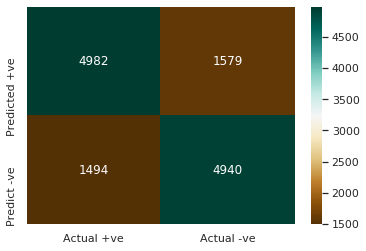

In [128]:
cfm = confusion_matrix(y_test, predictions)

df_cfm = pd.DataFrame(data=cfm, columns=['Actual +ve', 'Actual -ve'], 
                                 index=['Predicted +ve', 'Predict -ve'])
plot_cfm = sns.heatmap(df_cfm, annot=True, fmt='d', cmap='BrBG')

#### Generate a classification report for predicted values, to hellp evaluate model based on Precision, Recall, F-1 score.

In [129]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      6561
           1       0.76      0.77      0.76      6434

    accuracy                           0.76     12995
   macro avg       0.76      0.76      0.76     12995
weighted avg       0.76      0.76      0.76     12995



### ROC Curve

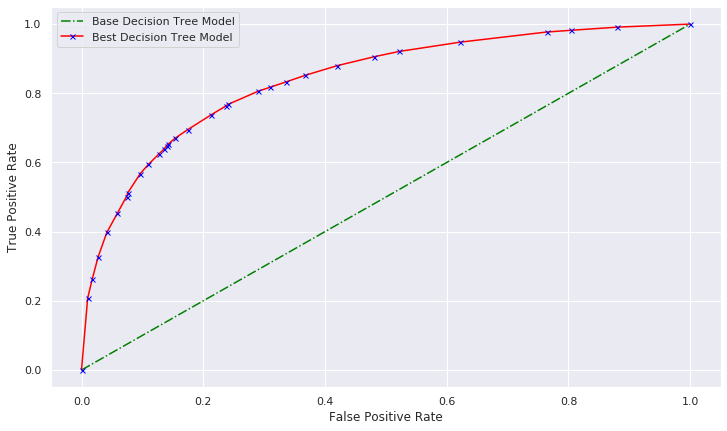

In [130]:
plt.figure(figsize=(12,7))
base_probs = [0 for _ in range(len(y_test))]
 
best_probs = model.predict_proba(x_test)
best_probs = best_probs[:, 1]

base_fpr, base_tpr, _ = roc_curve(y_test, base_probs)
best_fpr, best_tpr, _ = roc_curve(y_test, best_probs)

plt.plot(base_fpr, base_tpr, linestyle='dashdot', label='Base Decision Tree Model',color='Green')
plt.plot(best_fpr, best_tpr, marker='x', label='Best Decision Tree Model',color='Red',markeredgecolor='Blue',markersize=5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

#### AUC score

#### Comparing the auc score of base model and best model. A random model can predict 50% of times correctly while our model at its best can predict correctly 84% of the times.

In [131]:
base_auc = roc_auc_score(y_test, base_probs)
best_auc = roc_auc_score(y_test, best_probs)
print(base_auc)
print(best_auc)

0.5
0.8396846585050071


# K-Means

### Standardizing the dataset. Note that this dataset is already cleaned for NA's and outliers. Adding to that the categorical variables have also been converted into thhe dummies.

### KMeans is a Prototype type of Clustering.
#### Prototype clusters assign the centroid to each and every cluster and performs the iterative process to reposition the centroid based on minimum distance to the points. In case of categorical variables, medoid is calculated instead of centroid. Now, both the things are not possibile to perform in same cluster. So, we use the data with dummy variables.
#### Standard Scaling: We use standard scaler to scale the data with various ranges using the z-score approach. It returns the numerical continuous data with standard normal distribution.

In [0]:
df_train4 = df_train2
df_train4 = pd.DataFrame(StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(df_train4), columns = df_train2.columns)
df_train5 = df_train4

#### Running a loop to find the ideal number of clusters for grouping the data. Calculating the SSE (Sum of squared errors) to plot elbow curve and look for the sharp direction changing point.

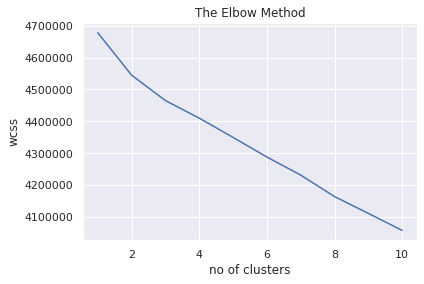

In [133]:
wcss=[]

for i in range(1,11):
    kmeans = KMeans(n_clusters= i, n_init=10, max_iter=100, random_state=0)
    kmeans.fit(df_train4)
    wcss.append(kmeans.inertia_)    
plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

#### The elbow curve returns clearly shows us that sharp elbow point occurs at K = 2. Hence, we will group the data into 2 clusters.

In [0]:
kmeans = KMeans(n_clusters = 2, n_init=25, max_iter=100, random_state=73)
clusters = kmeans.fit_predict(df_train4)

In [135]:
df_train4["km_pred"] = clusters
df_train4["km_pred"].unique()

array([0, 1])

### How to repurpose unsupervised learning for classification?
#### We can use the group name of clusters as the predicted classes of any classification model and compare it with actual values to measure evaluation parameters.

### Trial and error method:
#### When using cluster for classification purpose, we need to assign that either cluster 1 is RainTomorrow = Yes or RainTomorrow = No, same for Cluster 2 as well.
#### We assign some value, check the confusion matrix, if (TP + TN) is greater than (FP + FN), then we know that we have assigned the correct values otherwise we'll have to swtich the values.
#### Initially, assigning cluster 1 for RainTomorrow = Yes.

In [0]:
df_train4['actual_kmeans'] = df_target2

c1_no_rain  = df_train4[df_train4.km_pred == 1]
c2_yes_rain = df_train4[df_train4.km_pred == 0]

### How to judge the performance of clustering algorithms for classifications?
#### In classification we measure the degree to predicted class labels correspond to the actual class labels. To measure this thing, we use measures like Entropy, purity, precision, recall etc.
#### Based on that we'll calculate Entropy and Purity.
#### 1] Entropy

In [137]:
p_c1_1 = len(c1_no_rain[c1_no_rain.actual_kmeans == 1])/len(c1_no_rain)
p_c1_0 = len(c1_no_rain[c1_no_rain.actual_kmeans == 0])/len(c1_no_rain)

p_c2_1 = len(c2_yes_rain[c2_yes_rain.actual_kmeans == 1])/len(c2_yes_rain)
p_c2_0 = len(c2_yes_rain[c2_yes_rain.actual_kmeans == 0])/len(c2_yes_rain)

ent_clus_1 = -((p_c1_1 * math.log2(p_c1_1)) + (p_c1_0 * math.log2(p_c1_0)))
ent_clus_2 = -((p_c2_1 * math.log2(p_c2_1)) + (p_c2_0 * math.log2(p_c2_0)))               
   

total_entropy = ((len(c1_no_rain) * ent_clus_1)+(len(c2_yes_rain) * ent_clus_2))/ len(df_train4) 
total_entropy

0.9793167535329377

#### 2] Purity

In [138]:
pur_c1 = max(p_c1_1, p_c1_0)
print("The purity for cluster 1 is: ", pur_c1)

pur_c2 = max(p_c2_1, p_c2_0)
print("The purity for cluster 1 is: ", pur_c2)

The purity for cluster 1 is:  0.5638800729286245
The purity for cluster 1 is:  0.6056350626118068


In [139]:
print(f"Accuracy: {round(metrics.accuracy_score(actual_kmeans, df_train4.km_pred)*100)}%")

Accuracy: 42.0%


#### Create a confusion matrix and plot it.

#### Here we observe that False positive is less than false negatives. It means our precision value will be better than recall value. Here, RainTomorrow is predicted as 1, hence, we will think of reducing type 1 error. Also true positives and true negatives values are very high, so the accuracy of model will be high.

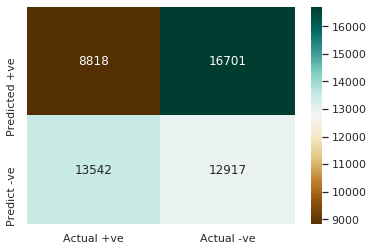

In [140]:
cfm = confusion_matrix(actual_kmeans, df_train4.km_pred)

df_cfm = pd.DataFrame(data=cfm, columns=['Actual +ve', 'Actual -ve'], 
                                 index=['Predicted +ve', 'Predict -ve'])
plot_cfm = sns.heatmap(df_cfm, annot=True, fmt='d', cmap='BrBG')

In [82]:
print(classification_report(actual_kmeans, df_train4.km_pred))

              precision    recall  f1-score   support

           0       0.39      0.35      0.37     25519
           1       0.44      0.49      0.46     26459

    accuracy                           0.42     51978
   macro avg       0.42      0.42      0.41     51978
weighted avg       0.42      0.42      0.42     51978



# HAC

##### Plotting the complete dendrogram

In [0]:
#from scipy.cluster.hierarchy import linkage,dendrogram
#merg = linkage(df_train5, method = "ward")
#dendrogram(merg, leaf_rotation = 90)
#plt.xlabel("data points")
#plt.ylabel("euclidean distance")
#plt.show()

#### Plotting the dendrogram for 2 clusters

In [0]:
#merg = linkage(df_train5, method = "ward")
#dendrogram(merg, leaf_rotation = 90, p = 2, truncate_mode = "lastp")
#plt.xlabel("data points")
#plt.ylabel("euclidean distance")
#plt.show()

#### HAC Model: Hyperparameters
####  1] Affinity: Here we have to specify that which distance we should consider between the data points, Euclidean distance or manhattan distance. We selected Euclidean for our model as it returned a better f1-score than mahattan distance.
#### 2] Linkage: We use ward linkage as it is robust and insensitive to the outliers.
#### 3] n_clusters: No of clusters we specify as 2, since we alreay know from elboe curve that 2 is the best number for clusters.

In [0]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "ward")
cluster = hc.fit_predict(df_train5)
df_train5["hac_pred"] = cluster

In [0]:
df_train5['actual_kmeans'] = actual_kmeans

c1_no_rain  = df_train5[df_train5.hac_pred == 1]
c2_yes_rain = df_train5[df_train5.hac_pred == 0]

In [52]:
p_c1_1 = len(c1_no_rain[c1_no_rain.actual_kmeans == 1])/len(c1_no_rain)
p_c1_0 = len(c1_no_rain[c1_no_rain.actual_kmeans == 0])/len(c1_no_rain)

p_c2_1 = len(c2_yes_rain[c2_yes_rain.actual_kmeans == 1])/len(c2_yes_rain)
p_c2_0 = len(c2_yes_rain[c2_yes_rain.actual_kmeans == 0])/len(c2_yes_rain)

ent_clus_1 = -((p_c1_1 * math.log2(p_c1_1)) + (p_c1_0 * math.log2(p_c1_0)))
ent_clus_2 = -((p_c2_1 * math.log2(p_c2_1)) + (p_c2_0 * math.log2(p_c2_0)))               
   

total_entropy = ((len(c1_no_rain) * ent_clus_1)+(len(c2_yes_rain) * ent_clus_2))/ len(df_train5) 
total_entropy

0.9972461103699662

In [53]:
pur_c1 = max(p_c1_1, p_c1_0)
print("The purity for cluster 1 is: ", pur_c1)

pur_c2 = max(p_c2_1, p_c2_0)
print("The purity for cluster 1 is: ", pur_c2)

The purity for cluster 1 is:  0.5391683354929909
The purity for cluster 1 is:  0.5198974010787974


In [54]:
print(f"Accuracy: {round(metrics.accuracy_score(actual_kmeans, df_train5.hac_pred)*100)}%")

Accuracy: 53.0%


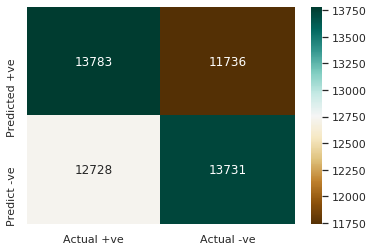

In [55]:
cfm = confusion_matrix(actual_kmeans, df_train5.hac_pred)

df_cfm = pd.DataFrame(data=cfm, columns=['Actual +ve', 'Actual -ve'], 
                                 index=['Predicted +ve', 'Predict -ve'])
plot_cfm = sns.heatmap(df_cfm, annot=True, fmt='d', cmap='BrBG')

In [56]:
print(classification_report(actual_kmeans, df_train5.hac_pred))

              precision    recall  f1-score   support

           0       0.52      0.54      0.53     25519
           1       0.54      0.52      0.53     26459

    accuracy                           0.53     51978
   macro avg       0.53      0.53      0.53     51978
weighted avg       0.53      0.53      0.53     51978



# Prediction of the Test Data

#### Preparing test data for decision tree model 

In [0]:
df_test2 = pd.get_dummies(df_test1)
df_test2.drop(['RainToday_No'] , axis = 1, inplace = True)
df_test2.drop(['ID'] , axis = 1, inplace = True)

#### Preparing test data for clustering model 

In [0]:
df_test4 = df_test2
df_test4 = pd.DataFrame(StandardScaler(copy=True, with_mean=True, with_std=True).fit_transform(df_test4), columns = df_test2.columns)
df_test5 = df_test4

#### Decision Tree deploy

In [59]:
DT_PRED = model.predict(df_test2)
DT_PRED

array([1, 0, 0, ..., 1, 0, 1], dtype=uint8)

#### K Means deploy

In [60]:
KMEANS_PRED = kmeans.predict(df_test4)
KMEANS_PRED

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

#### HAC deploy

In [61]:
HAC_PRED = hc.fit_predict(df_test5)
HAC_PRED

array([0, 0, 0, ..., 0, 1, 1])

In [0]:
HW2_Tejas_Excel = pd.DataFrame({'ID': df_test1.ID, 'DT_PRED': DT_PRED, 'KMEANS_PRED': KMEANS_PRED, 'HAC_PRED': HAC_PRED})

In [0]:
HW2_Tejas_Excel.to_csv(r'Downloads\HW2_Tejas_Excel.csv', index = False)